<center>Utilize the dataset that is provided to make a NBA predicition</center>

In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import random
Info2018_2019 = pd.read_csv('./data/Year_2018_2019.csv')

**Create the target, HomeWin. Create at least three new features from your dataset. Quantize all relevant features. Insert as many code and text cells as you need.**

Firstly, I fond more information to be features of each team from [this link](https://www.basketball-reference.com/). And I saved them as .csv file. Then I load them as features. A helper function is defined.

In [2]:
# read csv file and build information matrix
def initialize_data(Mstat, Ostat, Tstat):
    new_Mstat = Mstat.drop(['Rk', 'Arena'], axis=1)
    new_Ostat = Ostat.drop(['Rk', 'G', 'MP'], axis=1)
    new_Tstat = Tstat.drop(['Rk', 'G', 'MP'], axis=1)

    team_stats1 = pd.merge(new_Mstat, new_Ostat, how='left', on='Team')
    team_stats1 = pd.merge(team_stats1, new_Tstat, how='left', on='Team')

    # print(team_stats1.info())
    return team_stats1.set_index('Team', inplace=False, drop=True)

Mstat = pd.read_csv('./data/18-19Miscellaneous_Stat.csv')
Ostat = pd.read_csv('./data/18-19Opponent_Per_Game_Stat.csv')
Tstat = pd.read_csv('./data/18-19Team_Per_Game_Stat.csv')
team_stats = initialize_data(Mstat, Ostat, Tstat)

The match information is storaged in `Year_2018_2019.csv` file. Then load the match results needed with some helper functions. `X` denotes the features and `y` denotes the labels, which value of 1 means the winner team is Home team, otherwise the winner team is Visitor team.

In [3]:
base_elo = 1600
team_elos = {}
X = []
y = []


# calculate Elo score
def calc_elo(win_team, lose_team):
    winner_rank = get_elo(win_team)
    loser_rank = get_elo(lose_team)

    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif 2100 <= winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff

    return new_winner_rank, new_loser_rank

def get_elo(team):
    try:
        return team_elos[team]
    except:
        # if not, init elo score as base_elo
        team_elos[team] = base_elo
        return team_elos[team]
    
def build_dataSet(all_data):
    # print("Building data set..")
    for index, row in all_data.iterrows():
        WLoc = ''
        if float(row['PTS']) > float(row['PTS.1']):
            Wteam = row['Visitor/Neutral']
            Lteam = row['Home/Neutral']
            WLoc = 'V'
        else:
            Wteam = row['Home/Neutral']
            Lteam = row['Visitor/Neutral']
            WLoc = 'H'

        team1_elo = get_elo(Wteam)
        team2_elo = get_elo(Lteam)

        if WLoc == 'H':
            team1_elo += 100
        else:
            team2_elo += 100

        team1_features = [team1_elo]
        team2_features = [team2_elo]

        for key, value in team_stats.loc[Wteam].iteritems():
            team1_features.append(value)
        for key, value in team_stats.loc[Lteam].iteritems():
            team2_features.append(value)

        if WLoc=='H':
            X.append(team1_features + team2_features)
            y.append(1)
        else:
            X.append(team2_features + team1_features)
            y.append(0)

        new_winner_rank, new_loser_rank = calc_elo(Wteam, Lteam)
        team_elos[Wteam] = new_winner_rank
        team_elos[Lteam] = new_loser_rank

    return np.nan_to_num(X), np.array(y)


X, y = build_dataSet(Info2018_2019)

**Explore dataset. Show relevant statistics, tables, graphs, visualizations. Try to find relationships between your features and the target. Insert as many code and text cells as you need.**

Let's take a look inside of features.

In [4]:
print('X.shape=',X.shape)
print('Which means there are {} samples, and each sample has {} features.'.format(X.shape[0],X.shape[1]))
print('such as:Feature')
print(pd.DataFrame(X).head(10))
print('lables:(1 denotes HomeWin, 0 denotes VisitorWin)')
print(pd.DataFrame(y).head(10))

X.shape= (1312, 136)
Which means there are 1312 samples, and each sample has 136 features.
such as:Feature
      0     1     2     3     4     5     6     7     8      9    ...    \
0  1700.0  25.7  49.0  33.0  52.0  30.0  4.44 -0.54  3.90  112.2  ...     
1  1700.0  28.4  57.0  25.0  56.0  26.0  6.46 -0.04  6.42  115.9  ...     
2  1700.0  26.6  39.0  43.0  38.0  44.0 -1.10 -0.22 -1.32  111.4  ...     
3  1700.0  26.9  41.0  41.0  40.0  42.0 -0.24 -0.31 -0.56  109.0  ...     
4  1700.0  29.2  53.0  29.0  53.0  29.0  4.77  0.19  4.96  115.5  ...     
5  1700.0  27.0  48.0  34.0  50.0  32.0  3.33 -0.57  2.76  109.9  ...     
6  1700.0  27.2  48.0  34.0  43.0  39.0  0.85  0.23  1.09  112.4  ...     
7  1700.0  23.4  17.0  65.0  19.0  63.0 -9.21  0.28 -8.93  104.5  ...     
8  1700.0  25.7  42.0  40.0  43.0  39.0  0.71 -0.43  0.28  108.9  ...     
9  1700.0  24.0  19.0  63.0  19.0  63.0 -9.34  0.73 -8.61  105.9  ...     

     126   127   128   129   130  131  132   133   134    135  
0  

Plot the features. There is no significant feature only on when plot them.

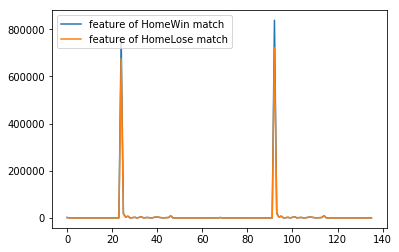

In [6]:
import matplotlib.pyplot as plt
f1=X[0,:]
f2=X[2,:]
plt.plot(f1)
plt.plot(f2)
plt.legend(['feature of HomeWin match','feature of HomeLose match'])
plt.show()

**Create the following ML models and report the training and testing accuracy of each:**

**Decision Tree Random Forest XGBoost Logistic Regression Naive Bayes (Gaussian) Use 80% of your data for training, and the remainder for testing. Use appropriate pruning and parameter tuning. Insert as many code and text cells as you need.**

And normally in machine learning, data sets should be shuffled.

In [7]:
per = np.random.permutation(len(y))
X = X[per, :]
y = y[per]

Split data sets to training set and test set. 80% of data should be for training, and remainder for testing.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('sample of trainning set:{},sample of test set:{}'.format(len(y_train), len(y_test)))

sample of trainning set:1049,sample of test set:263


Build and train **LogisticRegression** model

In [9]:
lr = LogisticRegression(penalty='l2', tol=0.00001, C=0.5, solver='liblinear')
lr.fit(X_train, y_train)
score_lr = lr.score(X_test, y_test)
score_lr_train = lr.score(X_train, y_train)
print('score of Logistic Regression model in test set is {:.4f} (score of training set:{:.4f})'.format(score_lr,score_lr_train))

score of Logistic Regression model in test set is 0.6920 (score of training set:0.7007)


Build and train **GaussianNB** model. 
more setting:https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [10]:
gnb = GaussianNB(var_smoothing=1e-09)
gnb.fit(X_train, y_train)
score_gnb = gnb.score(X_test, y_test)
score_gnb_train = gnb.score(X_train, y_train)
print('score of Naive Bayes (Gaussian) model in test set is {:.4f} (score of training set:{:.4f})'.format(score_gnb,score_gnb_train))

score of Naive Bayes (Gaussian) model in test set is 0.6996 (score of training set:0.6625)


Build and train **Random Forest** model.
more setting:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
score_rf = rf.score(X_test, y_test)
score_rf_train = rf.score(X_train, y_train)
print('score of Random Forest model in test set is {:.4f} (score of training set:{:.4f})'.format(score_rf,score_rf_train))

score of Random Forest model in test set is 0.5589 (score of training set:0.9724)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Build and train **Decision Tree** model.
more setting: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [12]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
score_dt = dt.score(X_test, y_test)
score_dt_train = dt.score(X_train, y_train)
print('score of Decision Tree model in test set is {:.4f} (score of training set:{:.4f})'.format(score_dt,score_dt_train))

score of Decision Tree model in test set is 0.6046 (score of training set:0.9990)


Build and train **XGBoost** model. 
more setting: https://dask-ml.readthedocs.io/en/stable/modules/generated/dask_ml.xgboost.XGBClassifier.html

In [13]:
xgb = XGBClassifier(learning_rate=0.01, max_depth=5)
xgb.fit(X_train, y_train)
score_xgb = xgb.score(X_test, y_test)
score_xgb_train = xgb.score(X_train, y_train)
print('score of XGBoost model in test set is {:.4f} (score of training set:{:.4f})'.format(score_xgb,score_xgb_train))

score of XGBoost model in test set is 0.6350 (score of training set:0.7969)


For summery info:

In [14]:
print('score of Logistic Regression model in test set is {:.4f} (score of training set:{:.4f})'.format(score_lr,score_lr_train))
print('score of Naive Bayes (Gaussian) model in test set is {:.4f} (score of training set:{:.4f})'.format(score_gnb,score_gnb_train))
print('score of Random Forest model in test set is {:.4f} (score of training set:{:.4f})'.format(score_rf,score_rf_train))
print('score of Decision Tree model in test set is {:.4f} (score of training set:{:.4f})'.format(score_dt,score_dt_train))
print('score of XGBoost model in test set is {:.4f} (score of training set:{:.4f})'.format(score_xgb,score_xgb_train))

score of Logistic Regression model in test set is 0.6920 (score of training set:0.7007)
score of Naive Bayes (Gaussian) model in test set is 0.6996 (score of training set:0.6625)
score of Random Forest model in test set is 0.5589 (score of training set:0.9724)
score of Decision Tree model in test set is 0.6046 (score of training set:0.9990)
score of XGBoost model in test set is 0.6350 (score of training set:0.7969)


**Analyze the models created from above question. Which ones were the best and why? Which ones were the worst? What made sense and what didn't? Insert as many code and text cells as you need. Explain your top two ML models with visualizations and words.**

since there are some random process in above functions, different trial will get different result. In one trial, result showed like:

**score of Logistic Regression model in test set is 0.6350 (score of training set:0.7140)**

**score of Naive Bayes (Gaussian) model in test set is 0.6274 (score of training set:0.6835)**

**score of Random Forest model in test set is 0.6008 (score of training set:0.9752)**

**score of Decision Tree model in test set is 0.6236 (score of training set:1.0000)**

**score of XGBoost model in test set is 0.6312 (score of training set:0.8036)**

In trainning set, decision tree is the best, but not in test test. Naive Bayes (Gaussian) performed worst with score of 0.6835. In the test set, Logistic Regression performed best(score of 0.6350) and Random Forest performed worst(score of 0.6008), The second best model is XGBoost model with score of 0.6312.

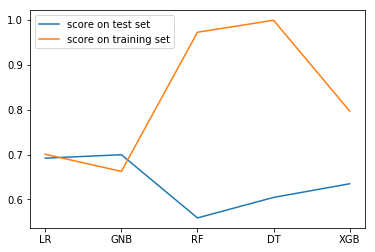

In [15]:
plt.plot(['LR','GNB','RF','DT','XGB'],[score_lr,score_gnb,score_rf,score_dt,score_xgb])
plt.plot(['LR','GNB','RF','DT','XGB'],[score_lr_train,score_gnb_train,score_rf_train,score_dt_train,score_xgb_train])
plt.legend(['score on test set','score on training set'])

**Test each ML model from Question 4 on the current partial year, 2019-2020, and report the accuracies for each. Insert as many code and text cells as you need. Was your best model still the best? Analyze and discuss the results.**

for this part, an .csv file named `Year_2019_2020.csv` should be storaged in `data` subpath. Re-load match info with code as below.

**Note:** if you do not have `Year_2019_2020.csv`, you will get an error as **FileNotFoundError: File b'data/Year_2019_2020.csv' does not exist**

In [17]:
result_data = pd.read_csv('./data/Year_2019_2020.csv')
X_2019, y_2019 = build_dataSet(team_stats, result_data)
score_lr = lr.score(X_2019, y_2019)
score_gnb = gnb.score(X_2019, y_2019)
score_rf = rf.score(X_2019, y_2019)
score_dt = dt.score(X_2019, y_2019)
score_xgb = xgb.score(X_2019, y_2019)
print('score of Logistic Regression model in test set is {:.4f}'.format(score_lr))
print('score of Naive Bayes (Gaussian) model in test set is {:.4f}'.format(score_gnb))
print('score of Random Forest model in test set is {:.4f}'.format(score_rf))
print('score of Decision Tree model in test set is {:.4f}'.format(score_dt))
print('score of XGBoost model in test set is {:.4f}'.format(score_xgb))

FileNotFoundError: File b'./data/Year_2019_2020.csv' does not exist

**Do at least two things that you think will improve your model's prediction capabilities for 2019-2020 (ie incorporate more data, engineer another feature, use a new ML model, normalize your data, etc). Insert as many code and text cells as you need.**

If pruning model needed, the websites are listed above for more parameter setting. For example, we create GaussianNB model with one line code `gnb = GaussianNB(var_smoothing=1e-09)`, if the [link](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) is checked,  two parameter(priors,var_smoothing) can be set. Please feel free to modify one or two parameter(s). That will be interesting if you implyment this part by yourself. examples:

xgb = XGBClassifier(learning_rate=0.01, max_depth=3)

lr = LogisticRegression(C=0.5, solver='liblinear')

**Re-evaluate: did it improve your model? Give relevant results and visualizations.**

This part result depends on your 2019-2020 schedule and match result. I think some report should finish by yourself.